<a href="https://colab.research.google.com/github/sadi-qa/INSE6220_Final_Project/blob/main/N_INSE6220_Final_Project_WineQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSE 6220 – Final Project
## PCA + Machine Learning Classification on Wine Quality Dataset

This notebook performs:
- Data loading & cleaning  
- Standardization  
- PCA (manual interpretation + graphs)  
- Machine learning classification (LR, KNN, RF)  
- Confusion matrices, ROC curves, accuracy & F1  
- Comparison between original features vs PCA features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_curve, auc
)

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (7,5)

## Step 1 — Load Wine Quality Dataset
We use the UCI Red Wine Quality dataset with 11 numerical features and a target quality score.


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Step 2 — Exploratory Data Analysis (EDA)
We examine:
- Missing values
- Summary statistics
- Quality distribution
- Correlation matrix

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


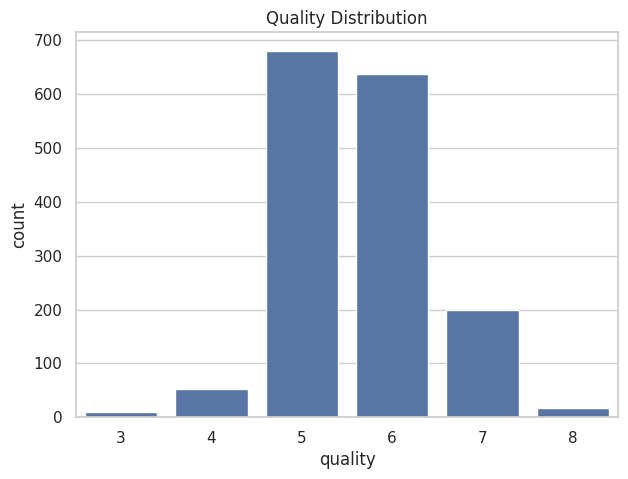

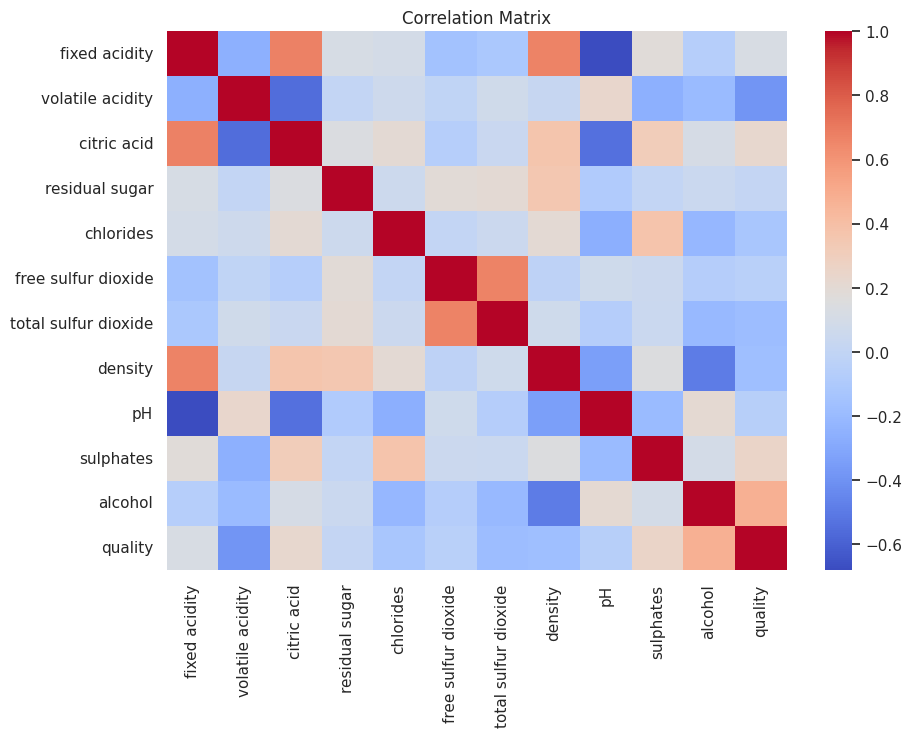

In [3]:
df.info()
df.describe()

plt.figure()
sns.countplot(x='quality', data=df)
plt.title("Quality Distribution")
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Step 3 — Create binary target: good_quality
Quality >= 6 → good (1)
Quality < 6 → not good (0)

In [4]:
df['good_quality'] = (df['quality'] >= 6).astype(int)
df['good_quality'].value_counts()

,count
good_quality,
1,855
0,744


## Step 4 — Train/Test Split & Standardization
We scale features because PCA and ML models perform better on standardized data.
Formula:
Z = (X - μ) / σ

In [5]:
X = df.drop(columns=['quality','good_quality'])
y = df['good_quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 5 — PCA
We compute:
- Covariance matrix: S = (1/(n−1)) ZᵀZ
- Eigenvalues/Eigenvectors: Sa = λa
- PCs: Z = XA

Plots:
- Scree Plot
- Cumulative Explained Variance (Pareto Plot)

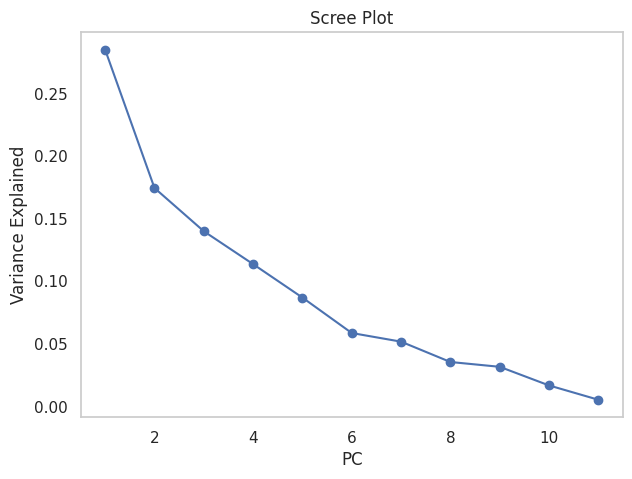

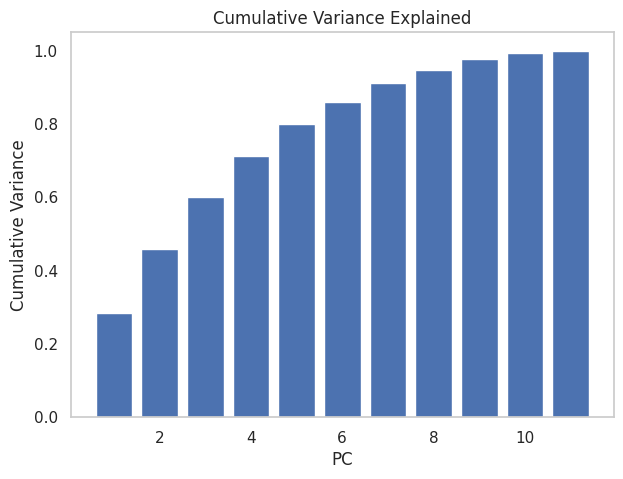

In [6]:
pca_full = PCA()
pca_full.fit(X_train_scaled)

expl_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

plt.plot(range(1, len(expl_var)+1), expl_var, marker='o')
plt.title("Scree Plot")
plt.xlabel("PC")
plt.ylabel("Variance Explained")
plt.grid()
plt.show()

plt.bar(range(1, len(cum_var)+1), cum_var)
plt.title("Cumulative Variance Explained")
plt.xlabel("PC")
plt.ylabel("Cumulative Variance")
plt.grid()
plt.show()

## Step 6 — Select PC1 and PC2
We select the first two components since they explain majority variance.

In [7]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=["PC1","PC2"]
)
loadings

,PC1,PC2
fixed acidity,0.486040,-0.100458
volatile acidity,-0.242499,0.302053
citric acid,0.456469,-0.154690
residual sugar,0.138754,0.256995
chlorides,0.230057,0.143481
free sulfur dioxide,-0.022311,0.517879
total sulfur dioxide,0.031702,0.567839
density,0.392735,0.223104
pH,-0.437812,-0.004843
sulphates,0.254356,-0.056311


## Step 7 — PCA Scatter Plot
Shows separability of good vs not-good wines in 2D PC space.

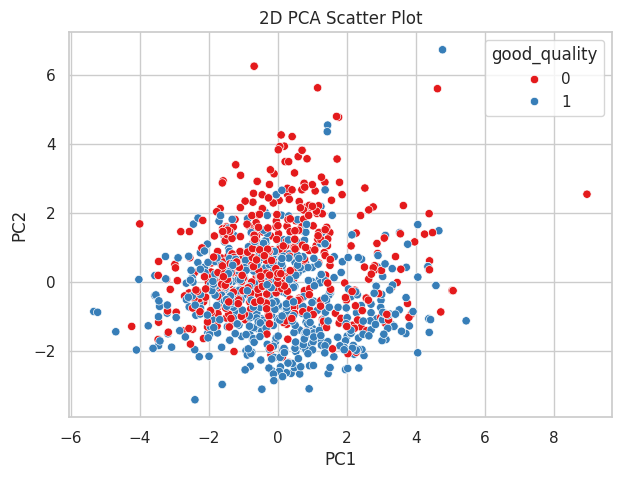

In [8]:
pca_df = pd.DataFrame(X_train_pca, columns=["PC1","PC2"])
pca_df['good_quality'] = y_train.values

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="good_quality", palette="Set1")
plt.title("2D PCA Scatter Plot")
plt.show()

## Step 8 — Train Logistic Regression, KNN, Random Forest
Compare performance using original features vs PCA features.

In [9]:
models = {
    "LR": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RF": RandomForestClassifier(n_estimators=200, random_state=123)
}

def eval(model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    f1 = f1_score(yte, pred)
    return acc, f1, pred

results = []

for name, model in models.items():
    acc, f1, pred = eval(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results.append(["Original", name, acc, f1])

for name, model in models.items():
    acc, f1, pred = eval(model, X_train_pca, X_test_pca, y_train, y_test)
    results.append(["PCA(2)", name, acc, f1])

results_df = pd.DataFrame(results, columns=["Features","Model","Accuracy","F1"])
results_df

,Features,Model,Accuracy,F1
0,Original,LR,0.747917,0.765957
1,Original,KNN,0.729167,0.754717
2,Original,RF,0.822917,0.835590
3,PCA(2),LR,0.670833,0.703008
4,PCA(2),KNN,0.612500,0.625000
5,PCA(2),RF,0.718750,0.734774


## Step 9 — Confusion Matrix & ROC Curve
Use Random Forest (best performing model) for visualization.

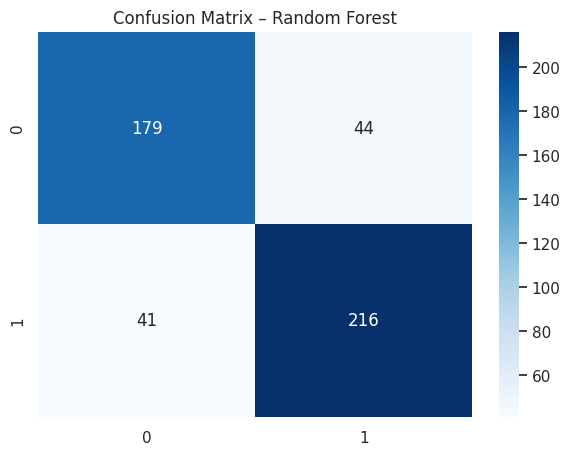

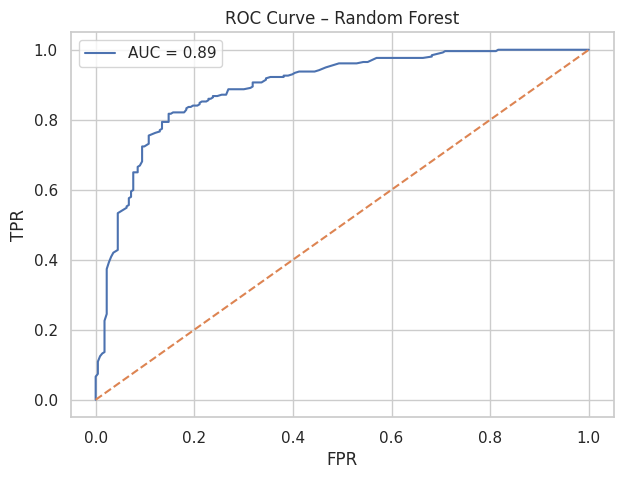

In [10]:
best_model = RandomForestClassifier(n_estimators=200, random_state=123)
best_model.fit(X_train_scaled, y_train)
pred = best_model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.show()

probs = best_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()